# Modelling and Evaluation
---

## Objectives

**Business Requirements Statement:**

The business requires the development of a dashboard to visually differentiate between healthy cherry leaves and those infected with powdery mildew. Additionally, the client aims to implement a predictive model capable of determining the overall health status of cherry trees, specifically identifying whether a tree is healthy or affected by powdery mildew. This initiative is intended to streamline the current manual inspection process, enhance efficiency, and potentially serve as a scalable solution for other crops within Farmy & Foods, contingent upon the success of the cherry leaf analysis project.

## Inputs

* inputs/cherry_leaves_dataset/cherry_leaves/train
* inputs/cherry_leaves_dataset/cherry_leaves/test
* inputs/cherry_leaves_dataset/cherry_leaves/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.
---

## Imports

In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib.image import imread
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Activation, Dropout, Flatten,
                                     Dense, Conv2D, MaxPooling2D)
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model
from PIL import Image
from tensorflow.keras.preprocessing import image
import random


---

## Check/Set the working directory

In [10]:
# Define the expected parent directory path
expected_parent_dir = ("c:\\Users\\2295883\\Downloads"
"\\cherry-leaves-mildew-detector-project-5-main")

# Get the current directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# Get the basename of the parent directory
parent_basename = os.path.basename(os.path.abspath(
    os.path.join(current_dir, os.pardir)))

# Check if the expected parent directory is the actual parent
if parent_basename != expected_parent_dir:
    # If not, change to the expected parent directory
    os.chdir(expected_parent_dir)
    print(f"Changed to the expected parent directory: {expected_parent_dir}")
else:
    print(f"Already in the expected parent directory: {parent_basename}")

# Check the current directory again
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")


Current directory: c:\Users\2295883\Downloads
Changed to the expected parent directory: c:\Users\2295883\Downloads\cherry-leaves-mildew-detector-project-5-main
Current directory: c:\Users\2295883\Downloads\cherry-leaves-mildew-detector-project-5-main


## Set input directories

In [3]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'


## Set/Create output directories

In [4]:
version = 'v1'
file_path = f'outputs/{version}'

outputs_dir = os.path.join(current_dir, 'outputs')

if 'outputs' in os.listdir(current_dir) and version in os.listdir(outputs_dir):
    print('An old version exists; create a new version.')
else:
    os.makedirs(name=file_path)


An old version exists; create a new version.


## Set labels

In [75]:
labels = os.listdir(train_path)
print('Image labels: ',labels)


Image labels:  ['healthy', 'powdery_mildew']


---

## Set image shape
image_shape = (dim1_mean, dim2_mean, 3)

In [14]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape


(256, 256, 3)

## Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 315 images
* validation - powdery_mildew: 315 images
* test - healthy: 317 images
* test - powdery_mildew: 317 images




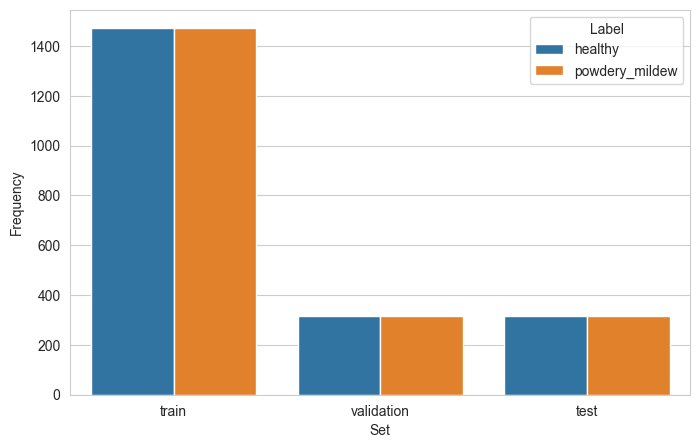

In [16]:
def calculate_labels_frequency(my_data_dir, labels):
    """
    Calculate the frequency of labels in each dataset split ('train',
    'validation', 'test').

    Parameters:
    - my_data_dir (str): The main directory containing subfolders representing
    different classes.
    - labels (list): List of class labels.

    Returns:
    - pd.DataFrame: DataFrame containing the frequency of each label in each
    dataset split.
    """

    df_freq = pd.DataFrame([])

    for folder in ['train', 'validation', 'test']:
        for label in labels:
            label_path = os.path.join(my_data_dir, folder, label)
            label_frequency = len(os.listdir(label_path))

            df_freq = pd.concat([
                df_freq,
                pd.DataFrame(data={
                    'Set': [folder],
                    'Label': [label],
                    'Frequency': [label_frequency]
                })
            ])

            print(f"* {folder} - {label}: {label_frequency} images")

    print("\n")
    return df_freq


def plot_labels_distribution(df_freq, file_path):
    """
    Plot and save the distribution of labels in each dataset split.

    Parameters:
    - df_freq (pd.DataFrame): DataFrame containing the frequency of each label
    in each dataset split.
    - file_path (str): Directory path to save the labels distribution plot.
    """

    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
    plt.savefig(os.path.join(file_path, 'labels_distribution.png'),
                bbox_inches='tight', dpi=150)
    plt.show()


df_frequency = calculate_labels_frequency(my_data_dir='inputs/'
                                          'cherry_leaves_dataset'
                                          '/cherry-leaves',
                                          labels=labels)
plot_labels_distribution(df_freq=df_frequency, file_path='outputs/v1')


## Image data augmentation

In [19]:
def create_image_data_generator(rotation_range=20, width_shift_range=0.1,
                                height_shift_range=0.1, shear_range=0.1,
                                zoom_range=0.1, horizontal_flip=True,
                                vertical_flip=True, fill_mode='nearest',
                                rescale=1./255):
    """
    Create an ImageDataGenerator with specified augmentation parameters.

    Parameters:
    - rotation_range: Degree range for random rotations.
    - width_shift_range: Fraction of total width for random horizontal shifts.
    - height_shift_range: Fraction of total height for random vertical shifts.
    - shear_range: Shear intensity (shear angle in radians).
    - zoom_range: Range for random zoom.
    - horizontal_flip: Boolean, randomly flip images horizontally.
    - vertical_flip: Boolean, randomly flip images vertically.
    - fill_mode: Points outside the boundaries are filled according to the
    mode.
    - rescale: Rescaling factor. If None or 0, no rescaling is applied.

    Returns:
    - ImageDataGenerator object.
    """
    return ImageDataGenerator(rotation_range=rotation_range,
                              width_shift_range=width_shift_range,
                              height_shift_range=height_shift_range,
                              shear_range=shear_range,
                              zoom_range=zoom_range,
                              horizontal_flip=horizontal_flip,
                              vertical_flip=vertical_flip,
                              fill_mode=fill_mode,
                              rescale=rescale
                              )


def create_image_data_flow(directory, image_shape, batch_size, data_generator):
    """
    Create a flow of images from a directory using the provided data generator.

    Parameters:
    - directory: Path to the target directory.
    - image_shape: Target size of images (height, width, channels).
    - batch_size: Number of images in each batch.
    - data_generator: ImageDataGenerator object.

    Returns:
    - Flow of images from the specified directory.
    """
    return data_generator.flow_from_directory(directory,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=(directory == train_path)
                                              )


# Set batch size
batch_size = 20

# Create image data generators
augmented_data_generator = create_image_data_generator()
normalization_data_generator = create_image_data_generator(rescale=1./255)

# Create data flows
train_set = create_image_data_flow(train_path, image_shape, batch_size,
                                   augmented_data_generator)
validation_set = create_image_data_flow(val_path, image_shape, batch_size,
                                        normalization_data_generator)
test_set = create_image_data_flow(test_path, image_shape, batch_size,
                                  normalization_data_generator)

# Print class indices
print("Class Indices - Train Set:", train_set.class_indices)
print("Class Indices - Validation Set:", validation_set.class_indices)
print("Class Indices - Test Set:", test_set.class_indices)


Found 2944 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Found 634 images belonging to 2 classes.
Class Indices - Train Set: {'healthy': 0, 'powdery_mildew': 1}
Class Indices - Validation Set: {'healthy': 0, 'powdery_mildew': 1}
Class Indices - Test Set: {'healthy': 0, 'powdery_mildew': 1}


## Plot augmented training, validation and test images

Displaying samples from the training set:
Sample 1 - Image Shape: (20, 256, 256, 3)


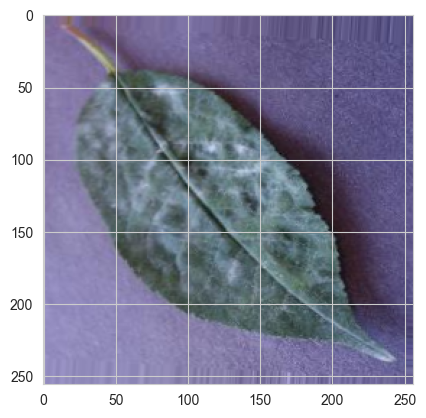

Sample 2 - Image Shape: (20, 256, 256, 3)


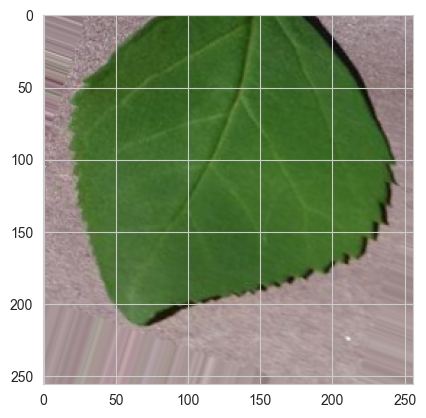

Sample 3 - Image Shape: (20, 256, 256, 3)


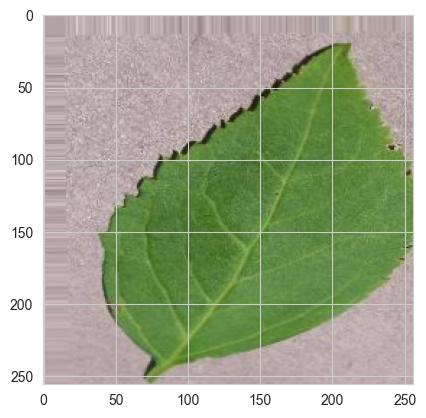

Displaying samples from the validation set:
Sample 1 - Image Shape: (20, 256, 256, 3)


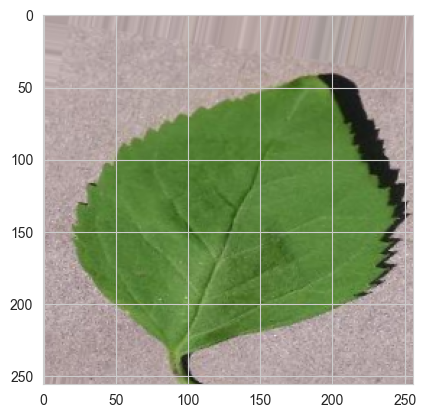

Sample 2 - Image Shape: (20, 256, 256, 3)


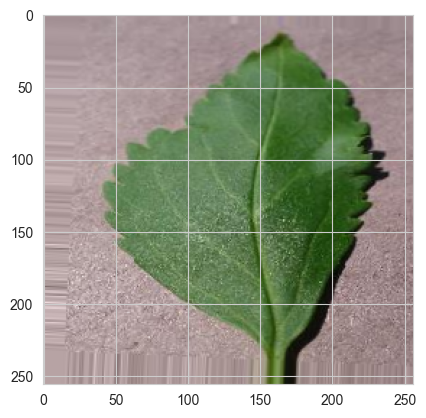

Sample 3 - Image Shape: (20, 256, 256, 3)


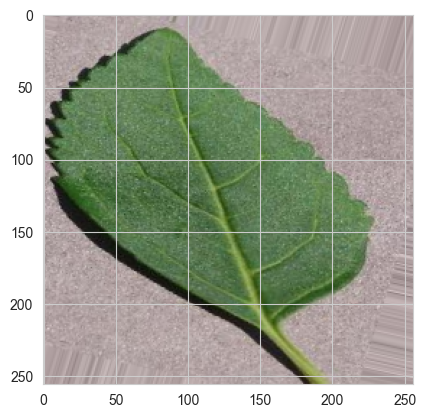

Displaying samples from the test set:
Sample 1 - Image Shape: (20, 256, 256, 3)


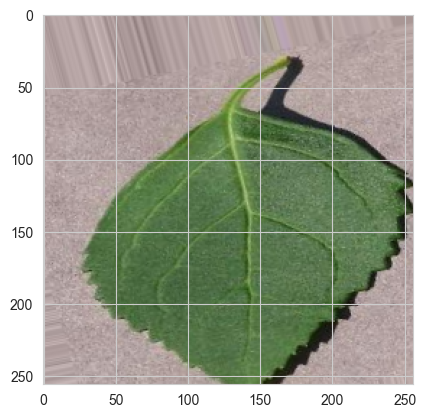

Sample 2 - Image Shape: (20, 256, 256, 3)


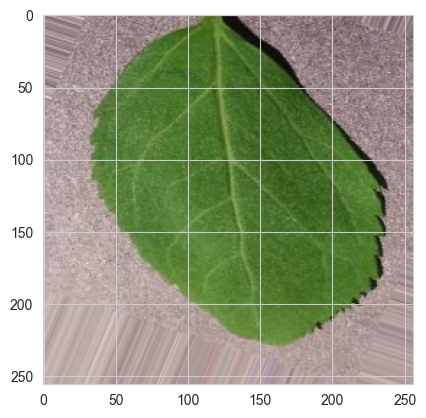

Sample 3 - Image Shape: (20, 256, 256, 3)


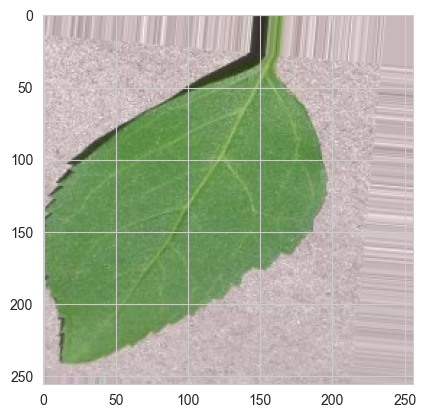

In [21]:
def display_data_samples(data_generator, dataset_name, num_samples=3):
    """
    Display a specified number of samples from the given data generator.

    Parameters:
    - data_generator: Data generator object.
    - dataset_name: Name of the dataset.
    - num_samples: Number of samples to display.

    Returns:
    - None
    """
    print(f"Displaying samples from the {dataset_name} set:")
    for i in range(num_samples):
        img, label = data_generator.next()
        print(f"Sample {i + 1} - Image Shape: {img.shape}")
        plt.imshow(img[0])
        plt.show()


# Display samples from the training set
display_data_samples(train_set, dataset_name="training")

# Display samples from the validation set
display_data_samples(validation_set, dataset_name="validation")

# Display samples from the test set
display_data_samples(test_set, dataset_name="test")


## Save class_indices

In [22]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model creation

In [24]:
def create_tf_model(image_shape):
    """
    Create a convolutional neural network (CNN) model using TensorFlow Keras.

    Parameters:
    - image_shape: Tuple representing the input image shape (height, width,
    channels).

    Returns:
    - model: Compiled CNN model.
    """
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(filters=24, kernel_size=(3, 3), input_shape=image_shape,
              activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer
    model.add(Conv2D(filters=12, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolutional layer
    model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth convolutional layer
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Dense layer
    model.add(Dense(128, activation='relu'))

    # Dropout layer to prevent overfitting
    model.add(Dropout(0.5))

    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


image_shape = (256, 256, 3)
model = create_tf_model(image_shape)
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 24)      672       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 24)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 12)      2604      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 12)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 8)         872       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 8)       

## Early Stopping

In [26]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)


## Fit model for model training

In [28]:
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set),
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


Epoch 1/25
148/148 [==============================] - 70s 472ms/step - loss: 0.0169 - accuracy: 0.9966 - val_loss: 0.0090 - val_accuracy: 0.9968
Epoch 2/25
148/148 [==============================] - 69s 465ms/step - loss: 0.0300 - accuracy: 0.9901 - val_loss: 0.0120 - val_accuracy: 0.9984
Epoch 3/25
148/148 [==============================] - 69s 466ms/step - loss: 0.0111 - accuracy: 0.9959 - val_loss: 0.0054 - val_accuracy: 0.9984
Epoch 4/25
148/148 [==============================] - 69s 465ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.0060 - val_accuracy: 0.9968
Epoch 5/25
148/148 [==============================] - 69s 466ms/step - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 6/25
148/148 [==============================] - 69s 468ms/step - loss: 0.0062 - accuracy: 0.9976 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 7/25
148/148 [==============================] - 70s 476ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0211 - val_ac

In [30]:
model.save('outputs/v1/mildew_detector_model.keras')


## Model Performace

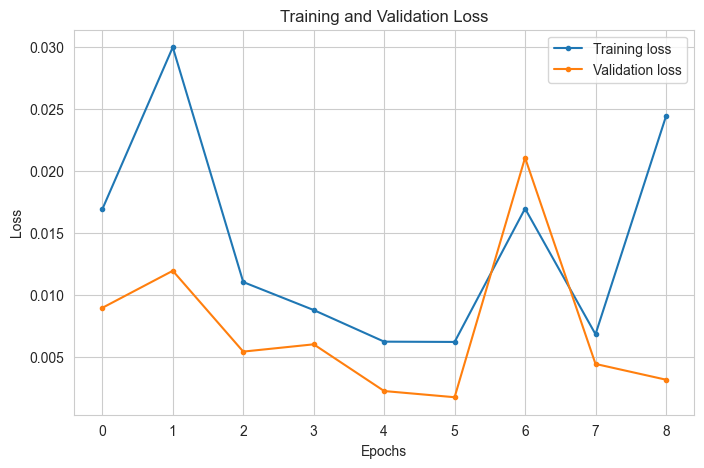

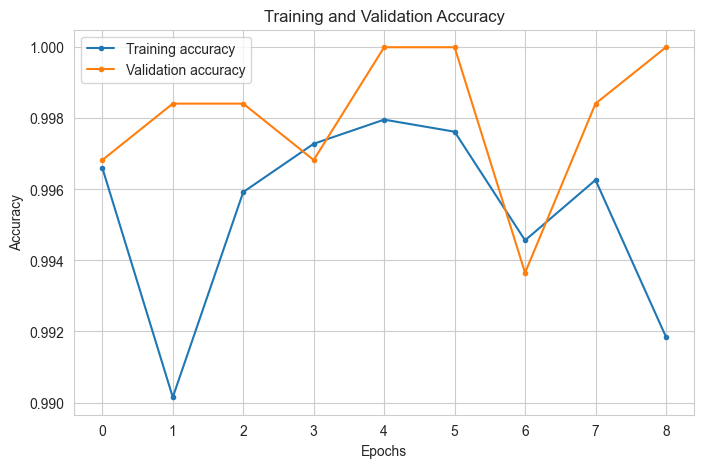

In [38]:
def plot_metric(history, metric, file_path, ylabel, title):
    """
    Plots and saves a specific metric (e.g., loss or accuracy) over epochs.

    Parameters:
    - history (keras.callbacks.History): The training history obtained from
    model training.
    - metric (str): The metric to be plotted.
    - file_path (str): The path where the plot will be saved.
    - ylabel (str): The label for the y-axis.
    - title (str): The title of the plot.

    Returns:
    None
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 5))

    plt.plot(history.history[metric], label=f'Training {metric}', marker='.')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}',
             marker='.')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

    # Save and display plot
    plt.savefig(f'{file_path}/model_training_{metric}.png',
                bbox_inches='tight', dpi=150)
    plt.show()


history = model.history

# Plot and save Loss
plot_metric(history, 'loss', file_path, 'Loss', 'Training and Validation Loss')

# Plot and save Accuracy
plot_metric(history, 'accuracy', file_path, 'Accuracy',
            'Training and Validation Accuracy')


The accuracy is higher than the required requirements.

## Model Evaluation

In [40]:
model = load_model('outputs/v1/mildew_detector_model.keras')


In [41]:
evaluation = model.evaluate(test_set)


32/32 [==============================] - 11s 331ms/step - loss: 0.0105 - accuracy: 0.9921


## Save evaluation pickle

In [42]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")


['outputs/v1/evaluation.pkl']

## Predict on new data
Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


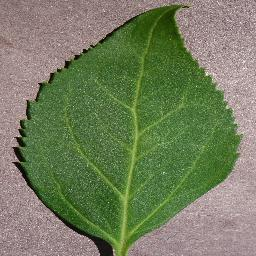

In [72]:
# Generate random values for 'healthy' or 'Powdery Mildew'
pointer = random.randint(0, len(os.listdir(test_path)) - 1)
label_index = random.randint(0, 1)
label = labels[label_index]

image_files = os.listdir(os.path.join(test_path, label))
selected_file = image_files[pointer]

image_path = os.path.join(test_path, label, selected_file)
pil_image = image.load_img(image_path, target_size=image_shape,
                           color_mode='rgb')

print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediction

In [73]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255
print(my_image.shape)


(1, 256, 256, 3)


Predict class probabilities

In [74]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 [==============================] - 0s 35ms/step
0.9999972013997649
healthy
